# Homework 2
Anders Dohlman

CBB 540

March 2018

***

In [286]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

## Problem 1. Gene Expression Data 

In [249]:
# Load Data
expdata = pd.read_table('hw1_genes.txt', sep=' ', header=None)
expdata.columns = [ 'gene{}'.format(i+1) for i in range(10) ]
display(expdata.head())

,gene1,gene2,gene3,gene4,gene5,gene6,gene7,gene8,gene9,gene10
0,7.864901,8.172362,8.345522,9.417973,7.369685,9.393602,7.649490,10.265107,9.353289,8.841578
1,9.538527,7.750893,8.775120,9.265158,8.865962,6.819702,7.188583,9.378603,8.549647,5.175128
2,8.091261,8.656986,8.735718,9.156024,8.137303,12.852049,7.998994,9.804414,8.755622,7.240488
3,9.048240,8.380023,10.077295,9.631237,6.116111,6.140508,7.494585,9.627057,8.375724,10.271147
4,7.184511,8.131421,8.476944,8.257558,6.253769,10.475141,7.137890,9.545679,9.172826,10.533741


### (a) Histograms

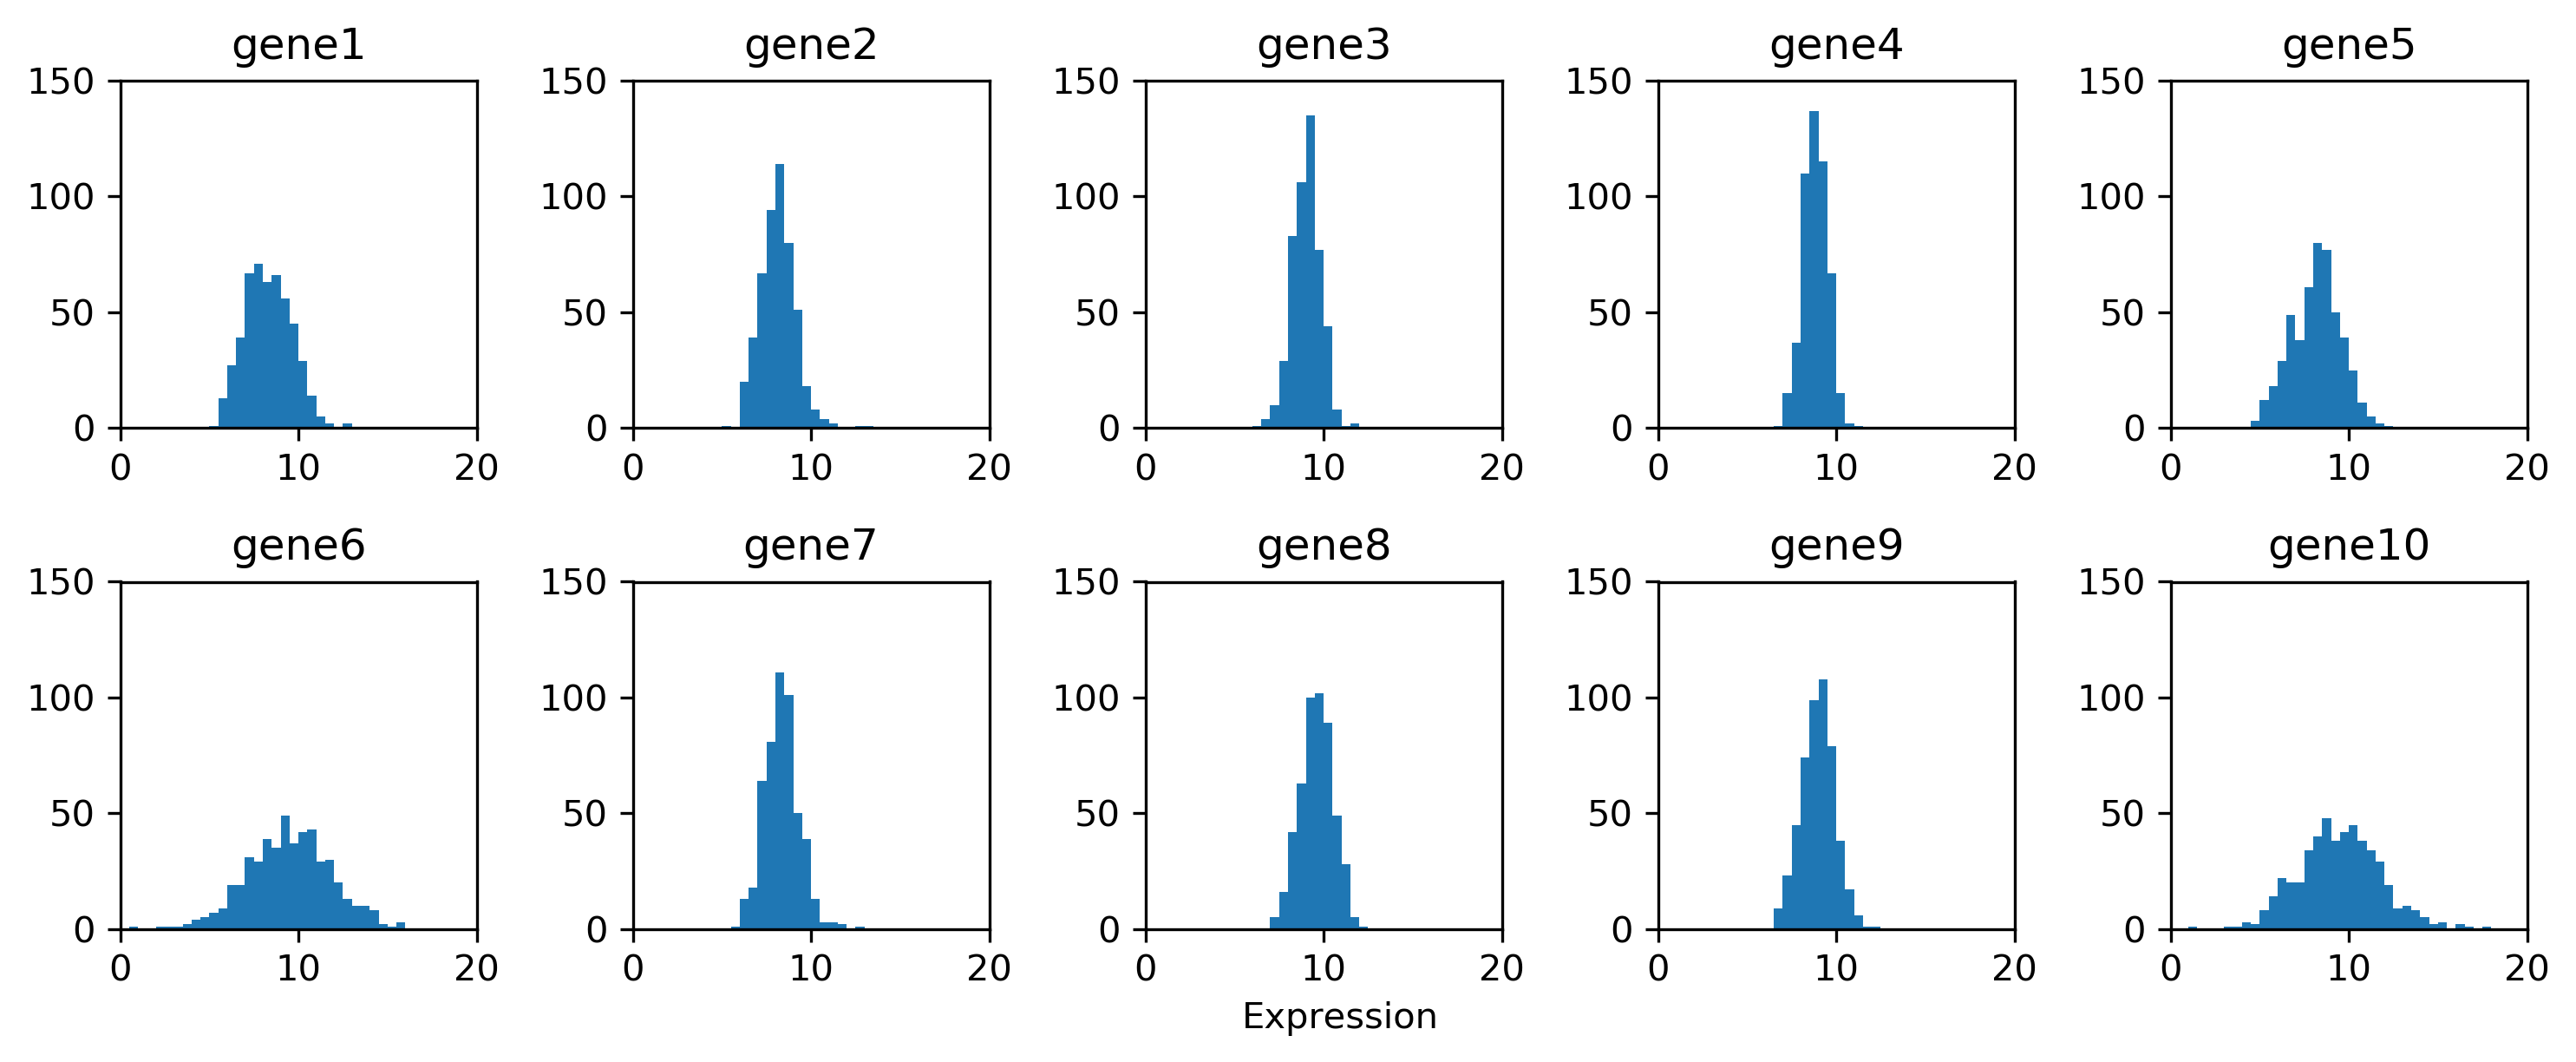

In [293]:
fig = plt.figure(figsize=(10,4), dpi=300)

for i, gene in enumerate(expdata.columns):
    
    ax = plt.subplot(2,5,i+1)
    
    plt.hist(expdata[gene], bins=np.arange(0,20,0.5))
    plt.axis([0,20,0,150])
    plt.title(gene)
    
fig.text(0.52,0,'Expression',ha='center')
plt.tight_layout()
plt.show()

Most of these genes appear normally distributed. However genes 1 and 7 have skew that stray from a normal distribution.

### (b) Quantile-Quantile Plots

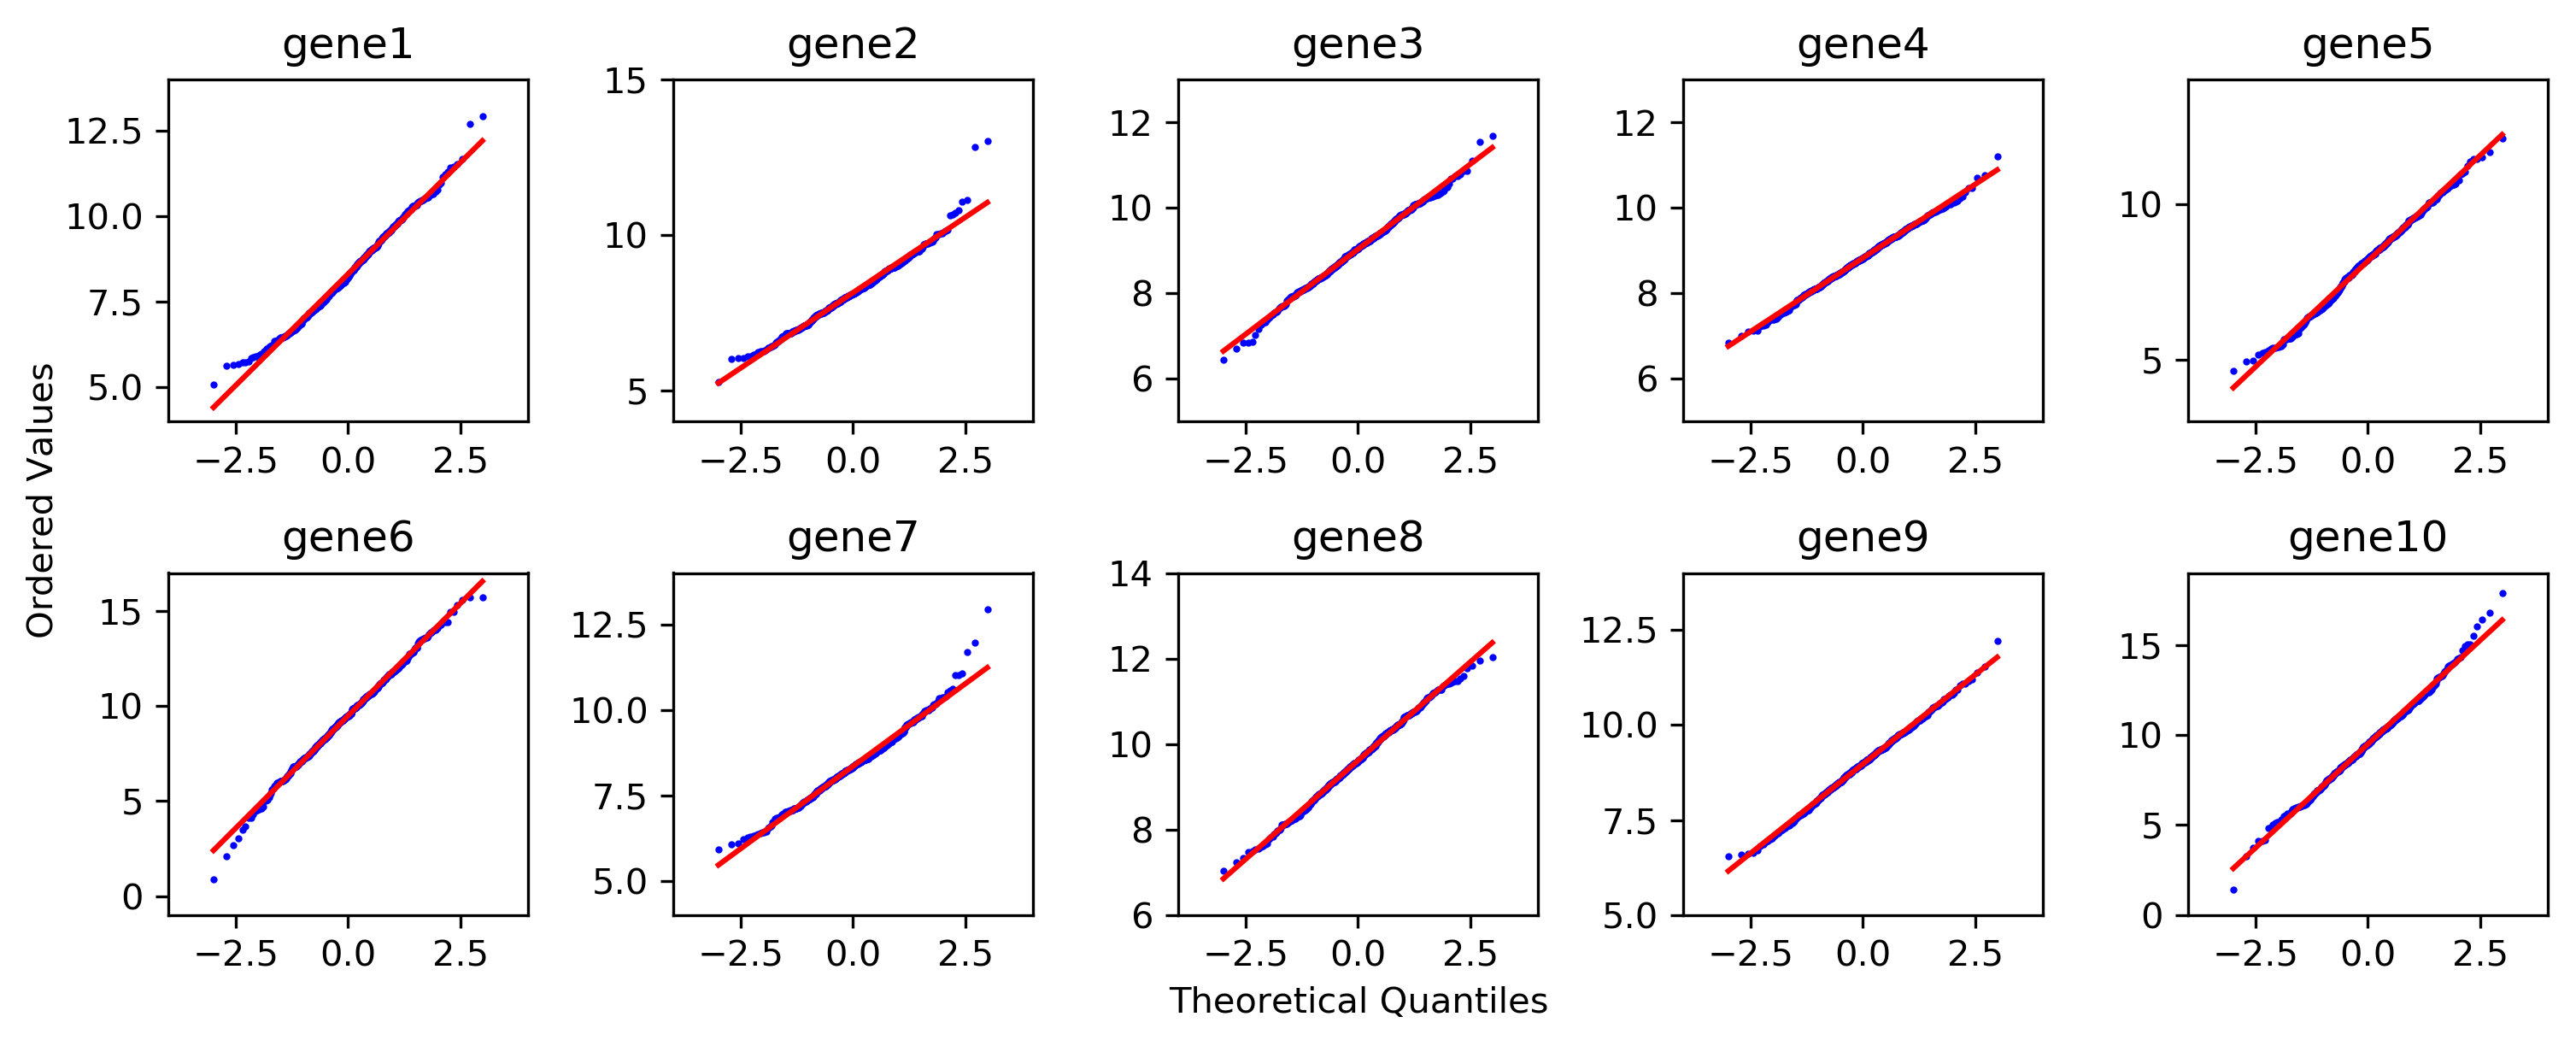

In [176]:
fig = plt.figure(figsize=(10,4), dpi=300)

for i, gene in enumerate(expdata.columns):
    
    ax = plt.subplot(2,5,i+1)
    
    x = expdata[gene]
    emin = np.floor(np.min(x)) - 1
    emax = np.ceil(np.max(x)) + 1
    
    stats.probplot(x, dist='norm',plot=ax)
    ax.get_lines()[0].set_markersize(1)
    plt.xlabel(''); plt.ylabel('')
    plt.axis([-4, 4, emin, emax])
    plt.title(gene)

fig.text(0.52,0,'Theoretical Quantiles',ha='center')
fig.text(0,0.5,'Ordered Values',va='center',rotation=90)
plt.tight_layout()
plt.show()

Again gene 2 and 7 seem furthest from normally distributed. However unlike in the histograms, genes 3, 7, and 10 also appear to stray from the normal distribution.

### (c) Standardizing

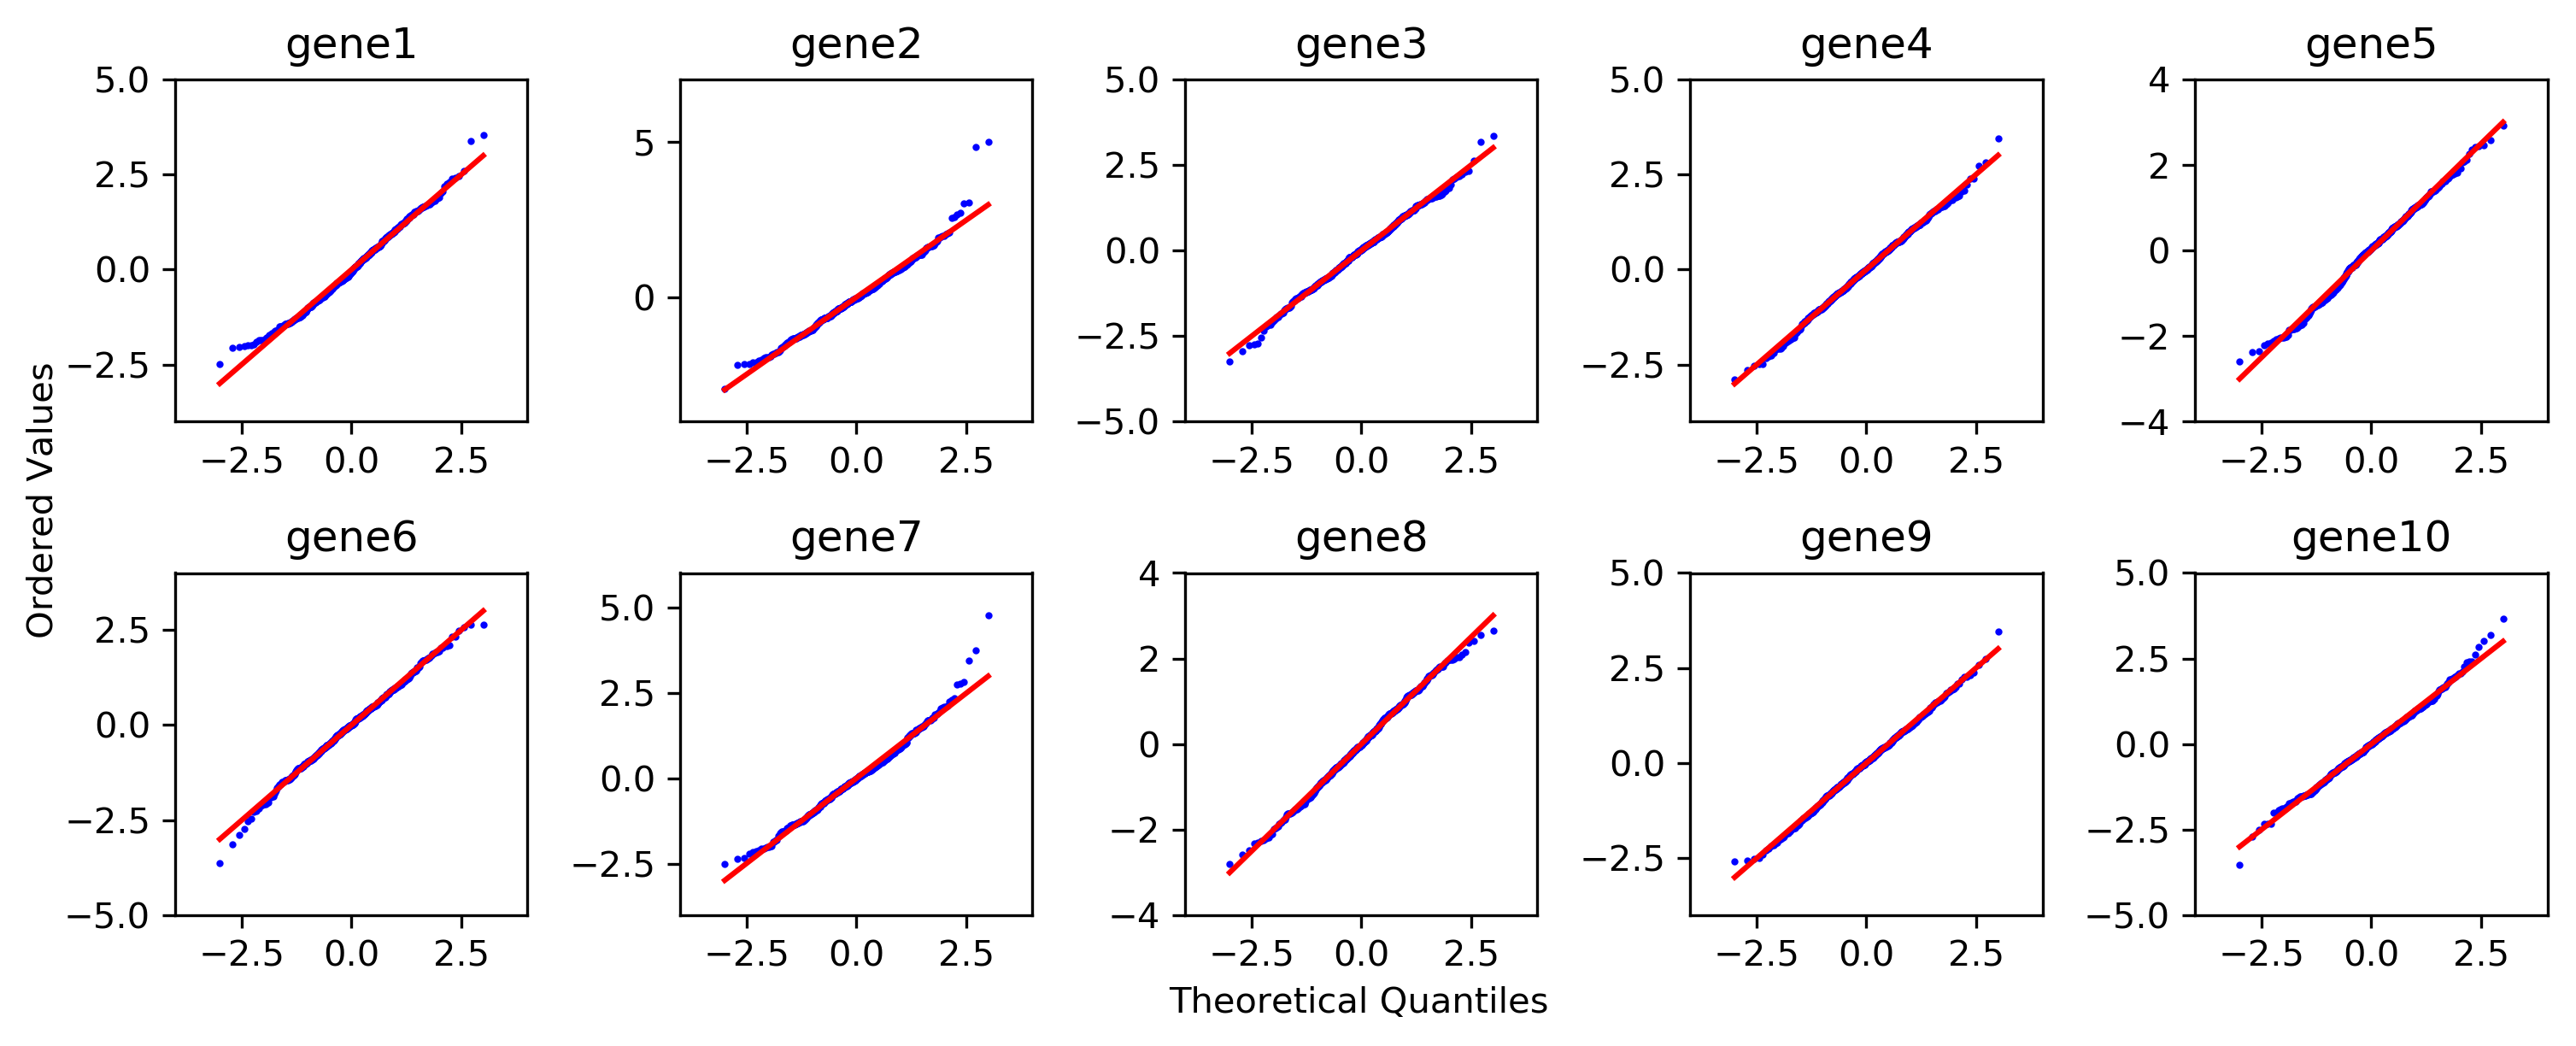

In [177]:
fig = plt.figure(figsize=(10,4), dpi=300)

for i, gene in enumerate(expdata.columns):
    
    ax = plt.subplot(2,5,i+1)
    
    x = stats.zscore(expdata[gene]) # standardize
    emin = np.floor(np.min(x)) - 1
    emax = np.ceil(np.max(x)) + 1
    
    stats.probplot(x, dist='norm',plot=ax)
    ax.get_lines()[0].set_markersize(1)
    plt.xlabel(''); plt.ylabel('')
    plt.axis([-4, 4, emin, emax])
    plt.title(gene)

fig.text(0.52,0,'Theoretical Quantiles',ha='center')
fig.text(0,0.5,'Ordered Values',va='center',rotation=90)
plt.tight_layout()
plt.show()

Does standardizing make the data look more or less similar to what is expected from a normal
distribution? Are outliers con- trolled?

### (d) Quantile Normalization

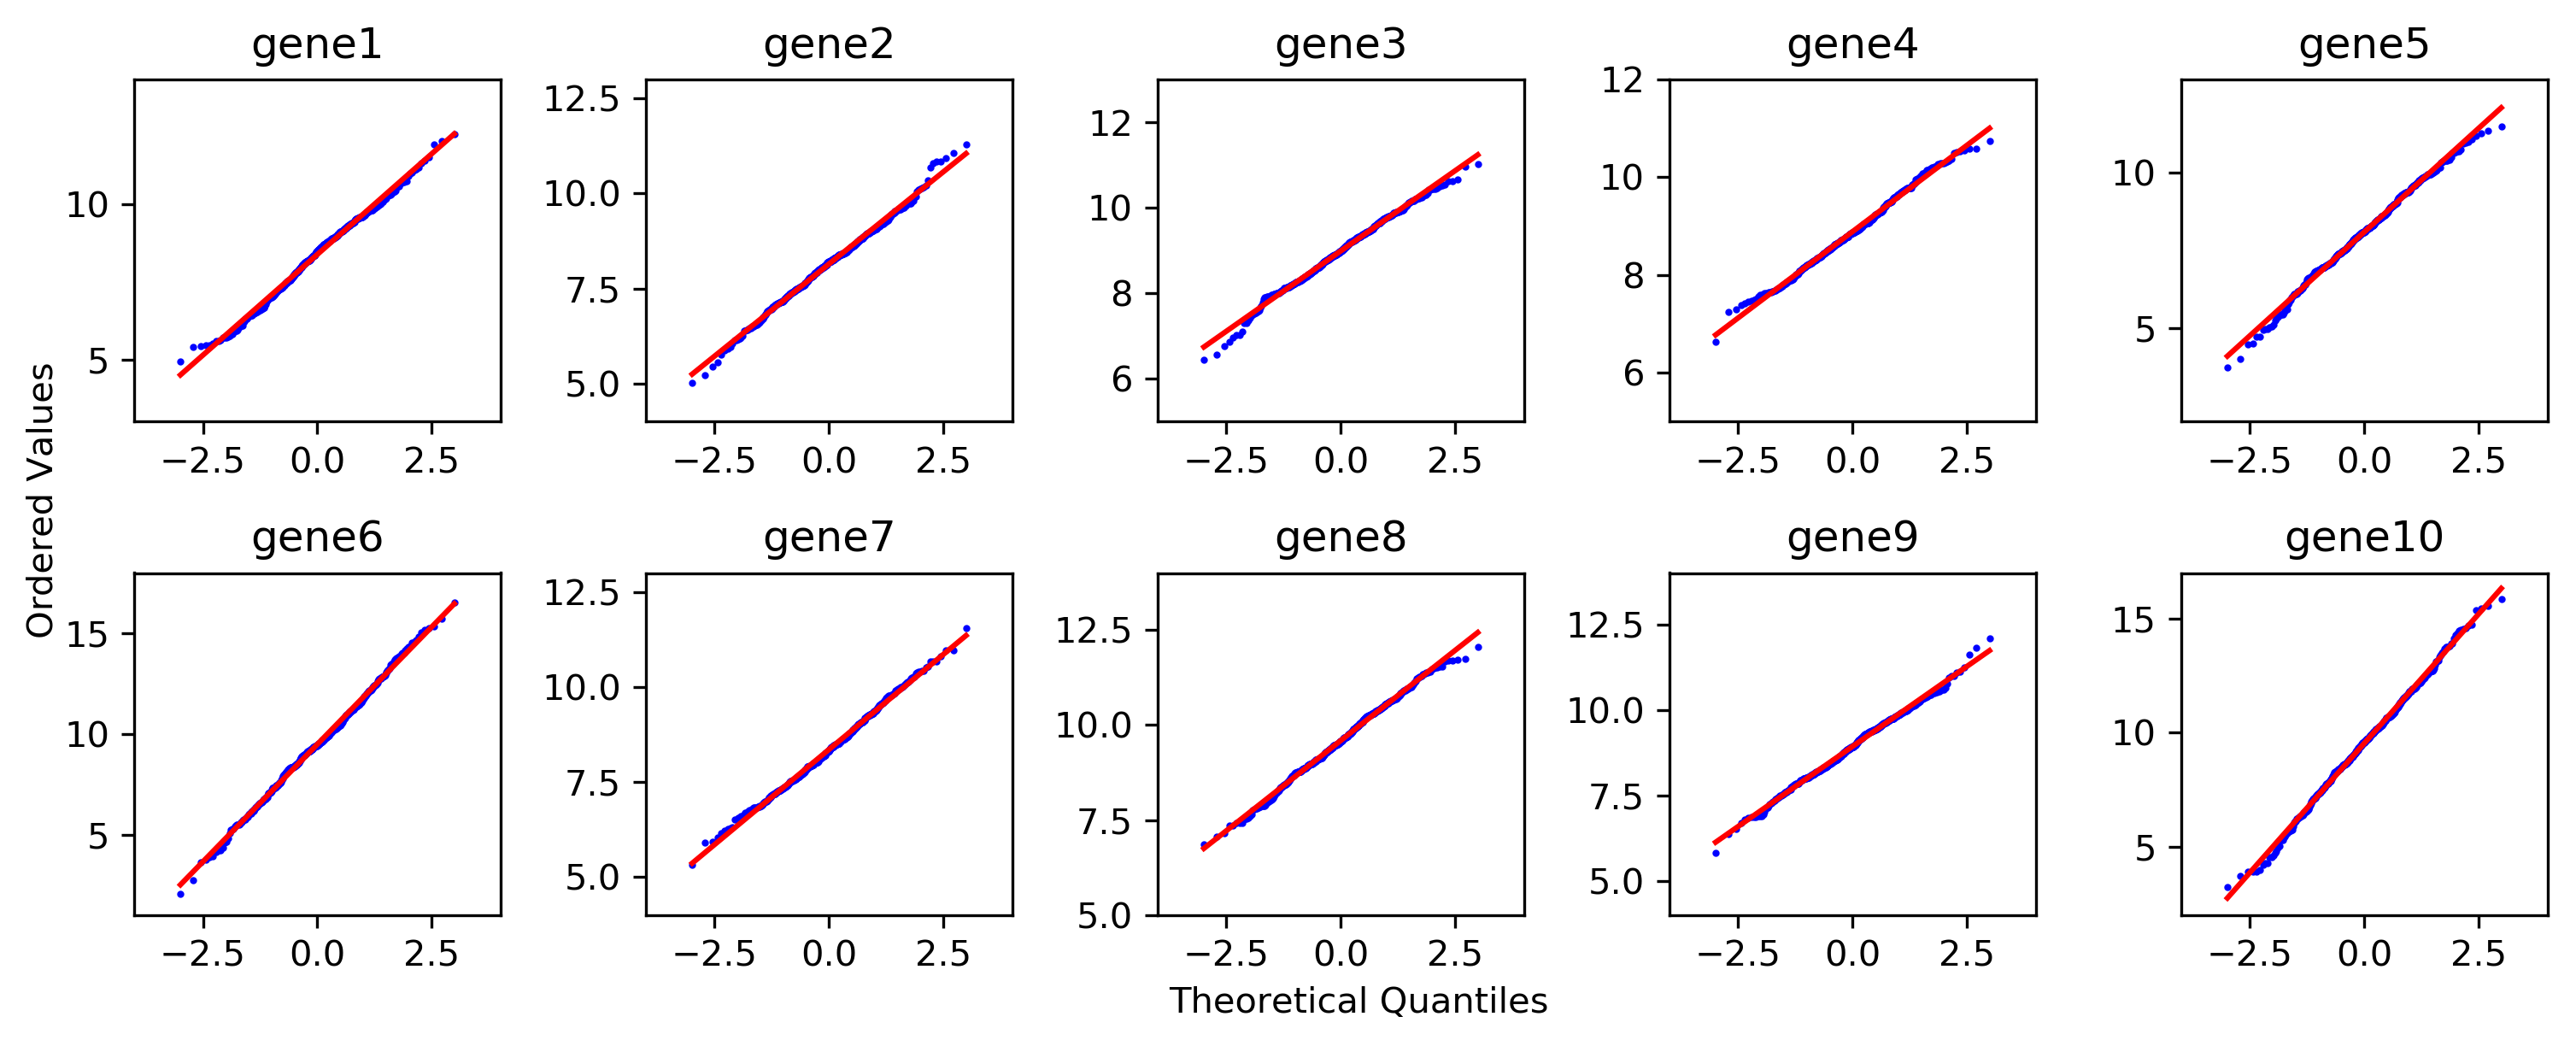

In [185]:
fig = plt.figure(figsize=(10,4), dpi=300)

for i, gene in enumerate(expdata.columns):
    
    ax = plt.subplot(2,5,i+1)
    
    x_raw = expdata[gene]
    x_norm = np.sort(np.random.normal(loc=np.mean(x_raw),
                                      scale=np.std(x_raw),
                                      size=len(x)))
    x = x_norm[x_raw.argsort().argsort()]
    
    emin = np.floor(np.min(x)) - 1
    emax = np.ceil(np.max(x)) + 1
    
    stats.probplot(x, dist='norm',plot=ax)
    ax.get_lines()[0].set_markersize(1)
    plt.xlabel(''); plt.ylabel('')
    plt.axis([-4, 4, emin, emax])
    plt.title(gene)

fig.text(0.52,0,'Theoretical Quantiles',ha='center')
fig.text(0,0.5,'Ordered Values',va='center',rotation=90)
plt.tight_layout()
plt.show()

More of the data now lie along the theoretical quantiles. Projecting the data onto the quantiles of a normal distribution appears to control the outliers.

### (e) Covariance

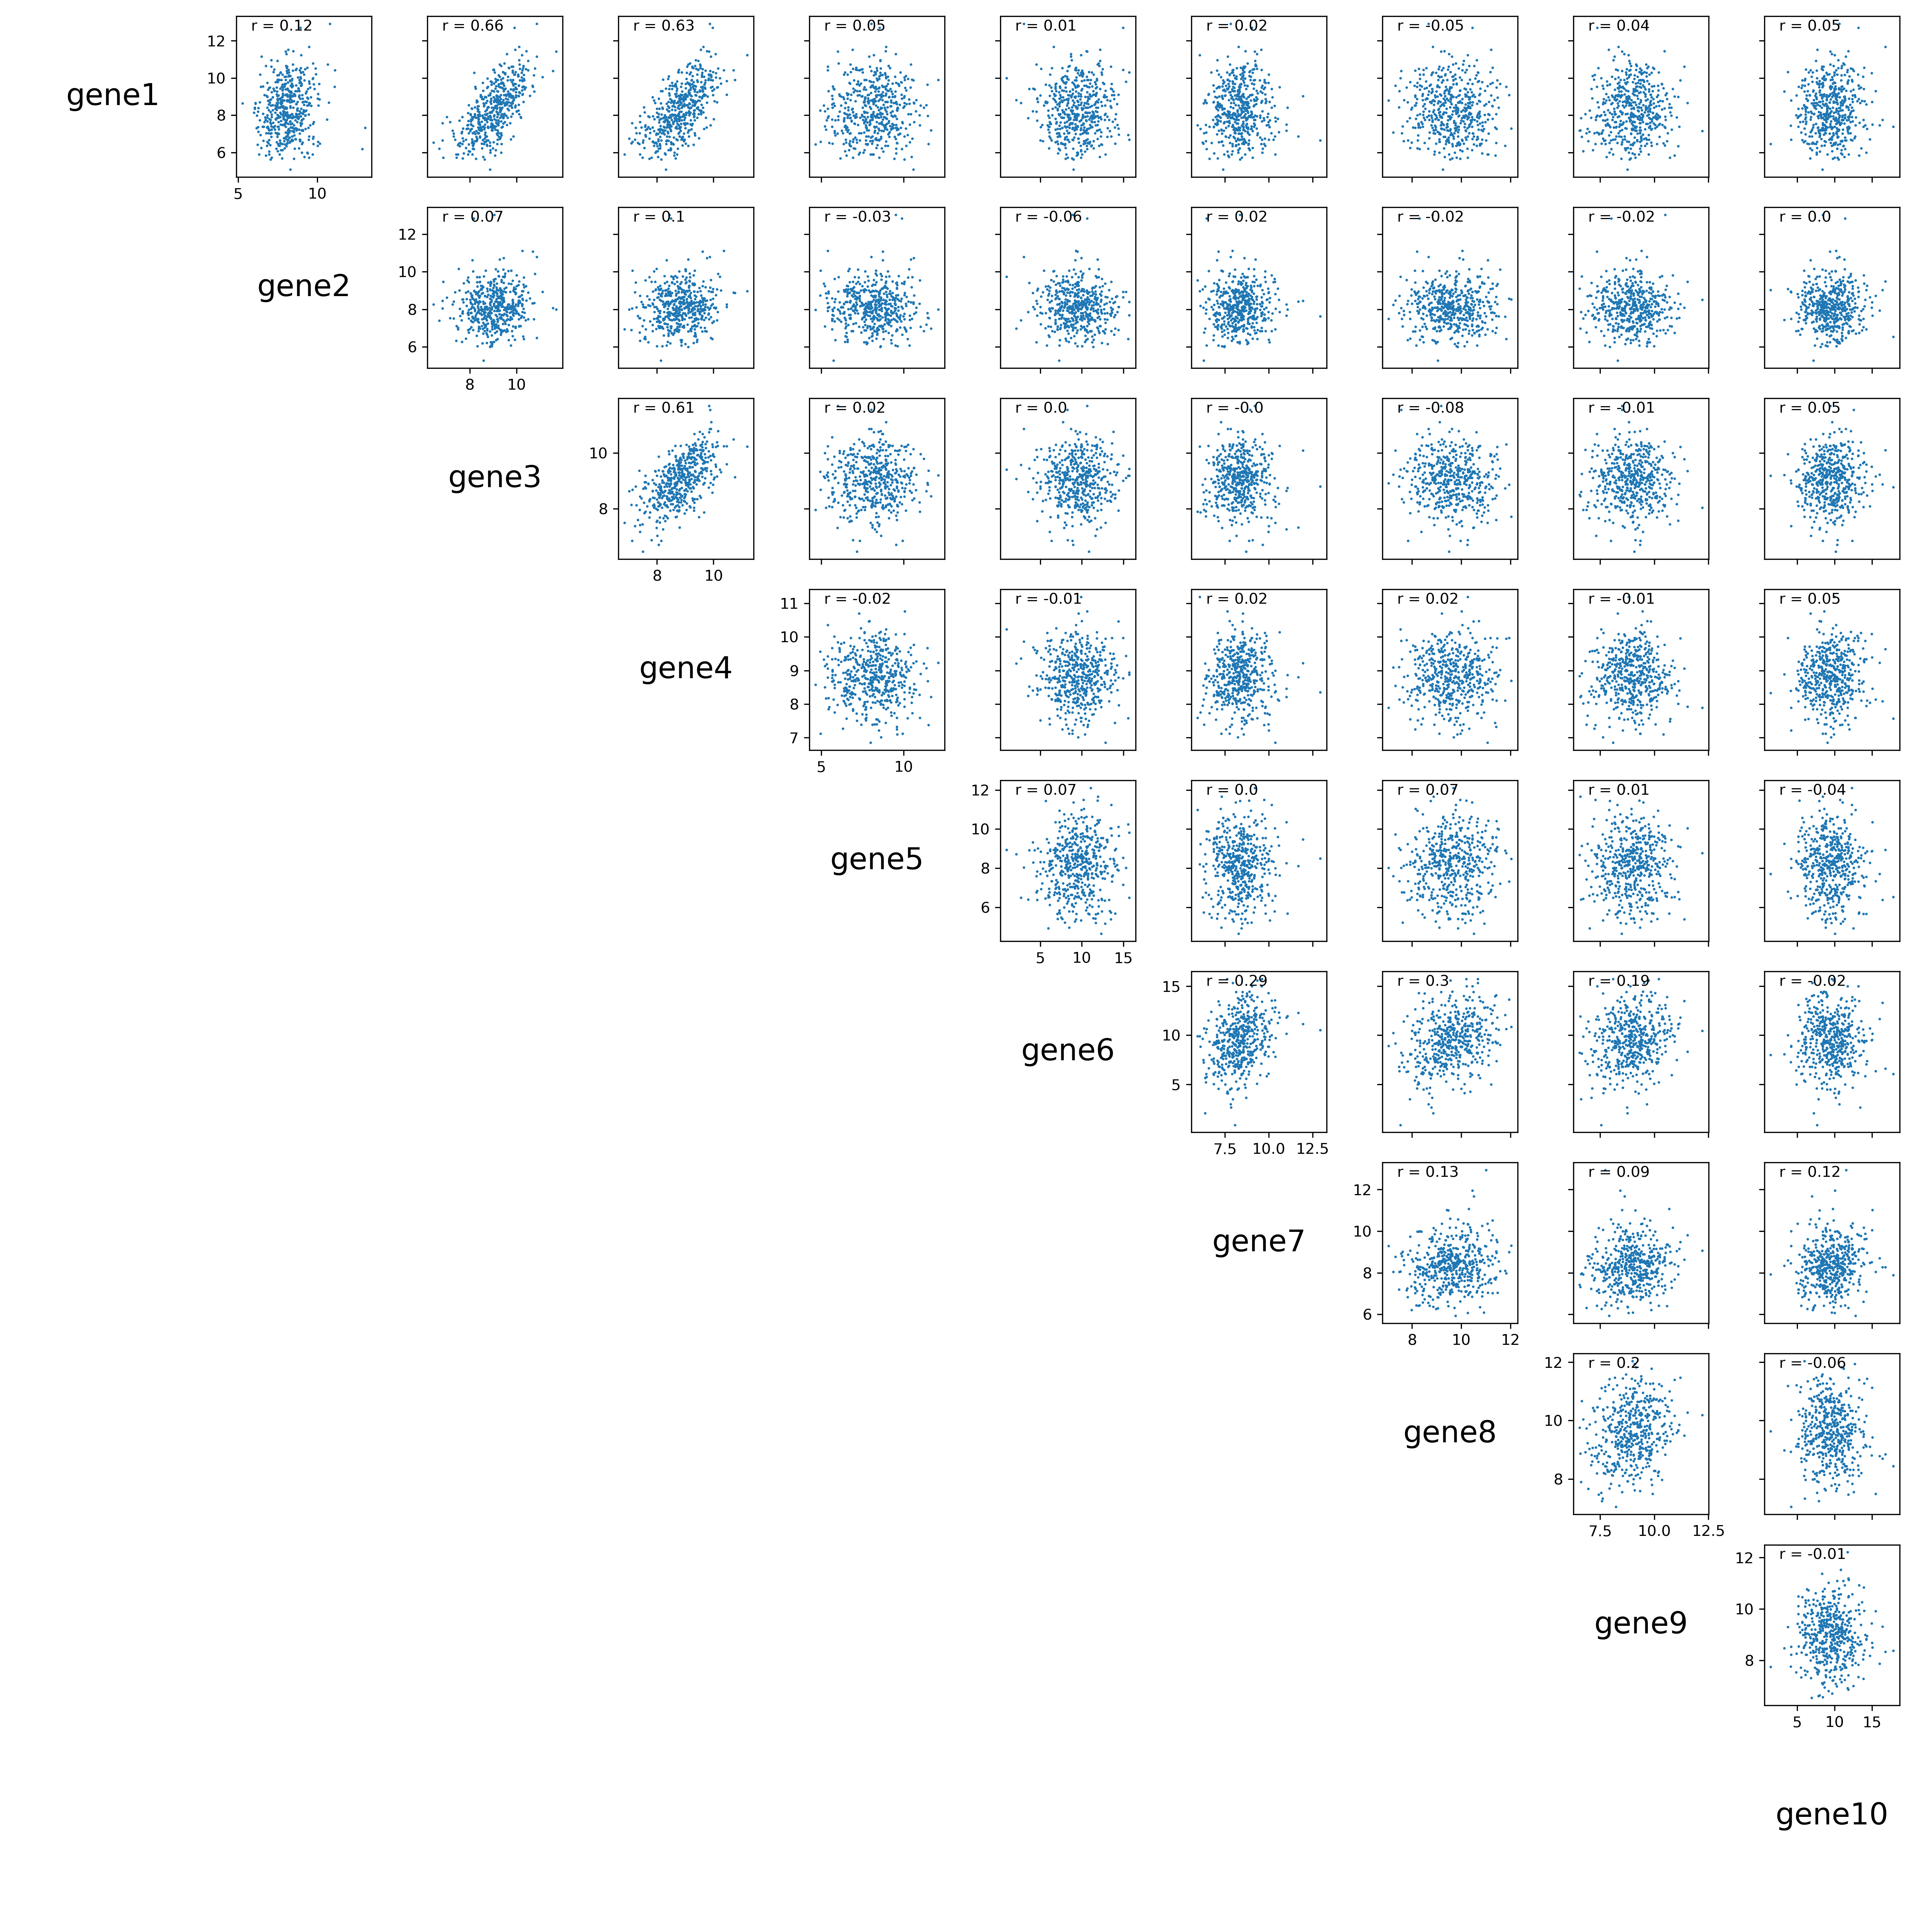

In [295]:
fig = plt.figure(figsize=(18,18), dpi=300)

for i, gene1 in enumerate(expdata.columns):
    for j, gene2 in enumerate(expdata.columns):
        
        n = i + 10*j + 1
        if i < j: continue
        
        ax = plt.subplot(10,10, n)
        
        x = expdata[gene1]
        y = expdata[gene2]
        
        if i != j:
            plt.scatter(x, y, s=0.5)
            r = np.round(stats.pearsonr(x,y)[0],decimals=2)
            plt.annotate('r = {}'.format(r), xycoords='axes points',
                        xy=(10,105), ha='left', va='top')
            if i != j + 1: ax.tick_params(labelbottom='off', labelleft='off')
        else:
            plt.text(0.5, 0.5, gene1, ha='center', va='center', fontsize=20)
            plt.axis('off')

plt.tight_layout(h_pad=0,w_pad=0)
plt.show()


It appears that genes 1, 3 and 4 appear are covariant, with coefficients of variation greater than 0.6.

## Problem 2.  Finding eQTLs

### (a) Gene-SNP Associations

In [296]:
snpdata = pd.read_table('hw1_genotypes.txt',sep=' ',header=None)
snpdata.columns = [ 'snp{}'.format(i+1) for i in range(5) ]
display(snpdata.head())

,snp1,snp2,snp3,snp4,snp5
0,0,2,1,1,1
1,0,0,2,1,2
2,2,0,1,1,2
3,0,2,2,1,2
4,2,0,1,1,1


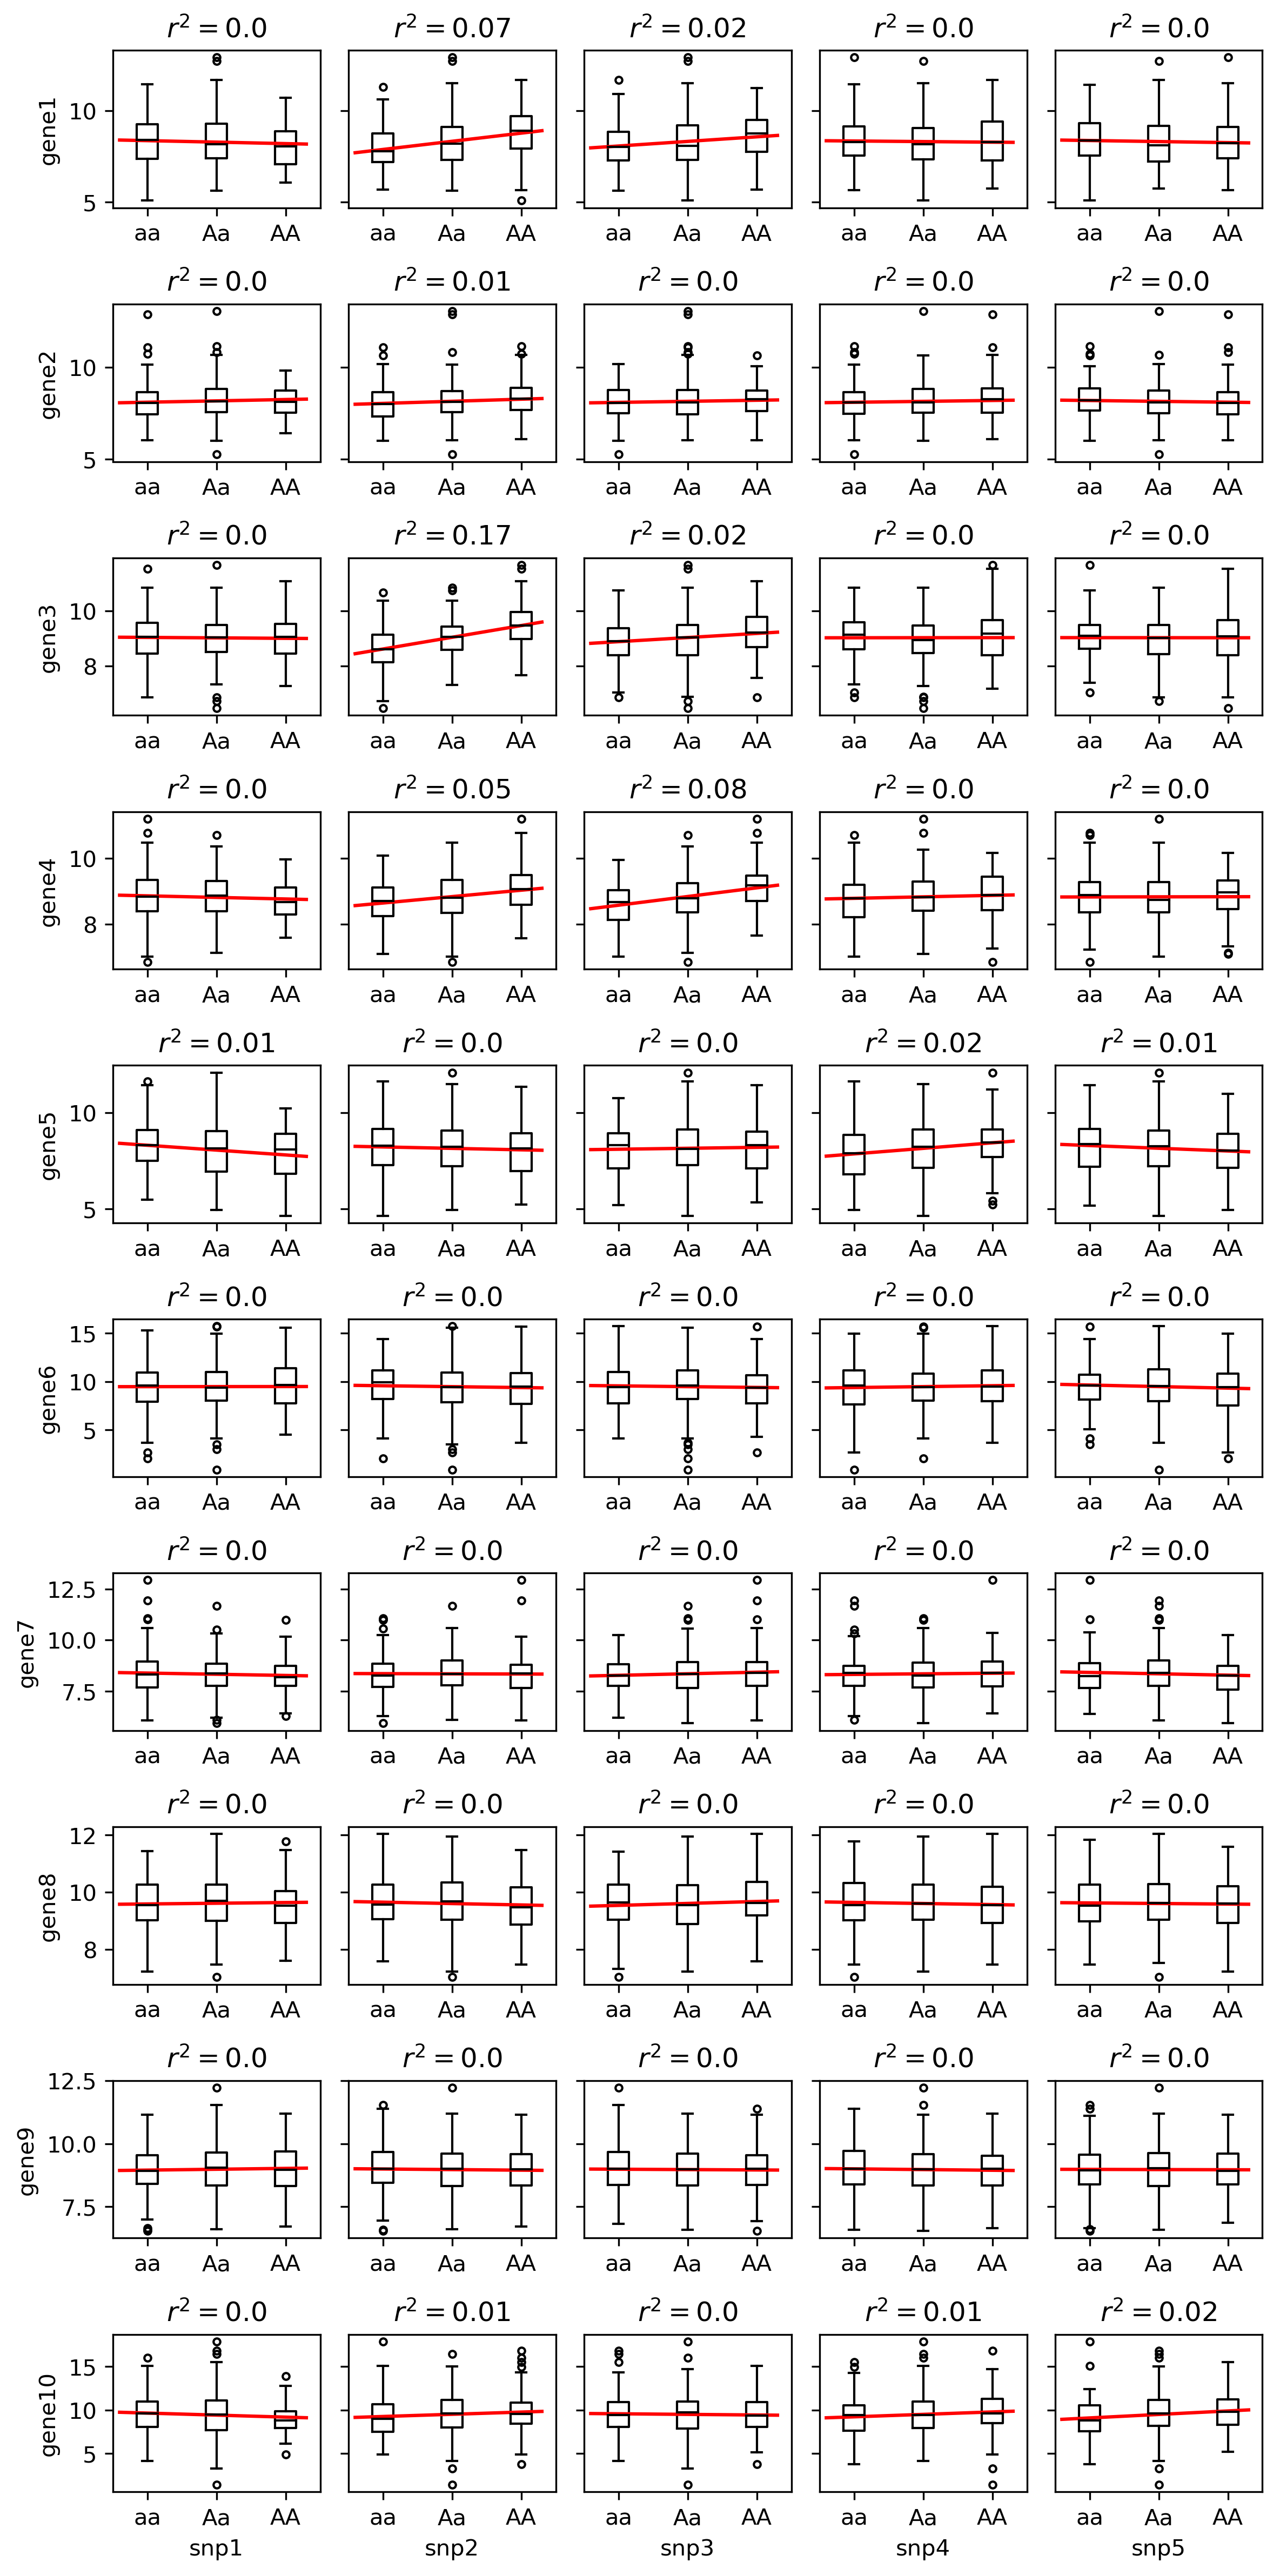

In [312]:
fig = plt.figure(figsize=(8,16), dpi=300)

for i, gene in enumerate(expdata.columns):
    
    for j, snp in enumerate(snpdata.columns):
        
        n = 5*i + j + 1
        ax = plt.subplot(10,5,n)
        
        x = snpdata[snp]
        y = expdata[gene]
        slope, intercept, r, p, stderr = stats.linregress(x,y)
    
        plt.boxplot([y[x==xi] for xi in [0,1,2]],labels=['aa','Aa','AA'],
                   medianprops={'color':'black'}, flierprops={'marker':'.'})
        
        domain = np.arange(0.6,3.4,0.1)
        plt.plot(domain, slope*(domain - 1) + intercept,'r')
        
        plt.title('$r^2 = {}$'.format(np.round(r**2, decimals=2)))
        if j == 0: plt.ylabel(gene)
        else: ax.tick_params(labelleft='off')            
        if i == 9: plt.xlabel(snp)

plt.tight_layout()
plt.show()

It appears that gene 3 is associated with SNP 2.

### (b) Best fit linear regression

See red line in plot above.

### (c) RSS and $r^2$

In [317]:
# snp1 and gene1 are not associated, but snp2 and gene3 are
for snp, gene in [('snp1','gene1'),('snp2','gene3')]:
    
    x = np.matrix(snpdata[snp]).T
    y = expdata[gene]
        
    regr = linear_model.LinearRegression().fit(x,y)
    y_fit = regr.predict(x)
    
    beta, beta0 = regr.coef_, regr.intercept_ 
    
    r2 = np.round(r2_score(y, y_fit), decimals=4)
    rss = np.round(500*mean_squared_error(y, y_fit), decimals=4)
    
    residuals = y - y_fit
    loglikelihood = np.sum(
        [np.log(1.0/np.sqrt(2*math.pi))*(-0.5*res**2)
        for res in residuals])
    
    print '[',snp,'vs',gene,']'
    print 'r^2 = {}'.format(r2)
    print 'RSS = {}'.format(rss)
    print 'logL = {}\n'.format(loglikelihood)


[ snp1 vs gene1 ]
r^2 = 0.0016
RSS = 844.2055
logL = 387.8864951

[ snp2 vs gene3 ]
r^2 = 0.1736
RSS = 259.2894
logL = 119.13548791



### (d) Likelihood

See calculation above.